# Модель оценки риска ДТП

## Описание проекта

Цель — создать модель, которая могла бы оценить риск ДТП по выбранному маршруту движения.

Краткое описание таблиц в базе данных:

1. collisions — общая информация о ДТП  

Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и 
когда.  

2. parties — информация об участниках ДТП  

Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая 
строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице 
должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id 
and party_number.  

3. vehicles — информация о пострадавших машинах  

Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и 
таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

## Установка и импорт библиотек, определение констант

In [2]:
# Сторонние библиотеки
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from category_encoders import CatBoostEncoder
from IPython.display import HTML, display
from matplotlib.patches import Patch
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    StandardScaler,
)
from sklearn.tree import DecisionTreeClassifier
from sqlalchemy import create_engine, inspect, text
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from phik.report import plot_correlation_matrix

# Типизация
from typing import List, Optional, Union

In [3]:
# константа RANDOM_STATE
RANDOM_STATE = 42

# константа TEST_SIZE
TEST_SIZE = 0.25

## Подключитесь к базе. Загрузите таблицы sql

In [12]:
# данные для подключения к БД
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

In [13]:
# строка для соединения с БД
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
db_config['user'],
db_config['pwd'],
db_config['host'],
db_config['port'],
db_config['db'],
)

In [14]:
# соединение для подключения к БД
engine = create_engine(connection_string)

## Проведите первичное исследование таблиц

Создадим запросы ко всем таблицам в БД, чтобы проверить наличие таблиц и всех столбцов на соответствие описанию

In [15]:
query_case_ids = 'SELECT * FROM case_ids LIMIT 3;'

In [16]:
case_ids_3 = pd.read_sql_query(query_case_ids, con=engine)
case_ids_3

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021


In [17]:
query_vehicles = 'SELECT * FROM vehicles LIMIT 3'

In [18]:
vehicles_3 = pd.read_sql_query(query_vehicles, con=engine)
vehicles_3

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3


In [19]:
query_collisions = 'SELECT * FROM collisions LIMIT 3'

In [20]:
collisions_3 = pd.read_sql_query(query_collisions, con=engine)
collisions_3

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00


In [21]:
query_parties = 'SELECT * FROM parties LIMIT 3'

In [22]:
parties_3 = pd.read_sql_query(query_parties, con=engine)
parties_3

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29,had not been drinking,None,0
1,23,3899454,2,road signs,0,7,had not been drinking,None,0
2,29,3899462,2,car,0,21,had not been drinking,None,0


Все таблицы и все признаки присутствуют в базе данных. Общим ключем является столбец `case_id`

Узнаем количество записей в таблицах

In [23]:
tables = ['case_ids', 'vehicles', 'collisions', 'parties']

counts = {}

with engine.connect() as conn:
    for table in tables:
        query = text(f"SELECT COUNT(*) FROM {table}")
        counts[table] = conn.execute(query).scalar()

# Выводим результаты
for table, count in counts.items():
    print(f"{table}: {count}")

case_ids: 1400000
vehicles: 1021234
collisions: 1400000
parties: 2752408


Наблюдаем различия в количестве строк. Предполагается, что это нормально, например, таблица `parties` представляет собой описание участников происшествия, а их может быть несколько в одном ДТП.

Выведем уникальные значения повреждений

In [24]:
query_unique_damage = 'SELECT DISTINCT collision_damage FROM collisions'

with engine.connect() as conn:
    result = conn.execute(query_unique_damage)
    unique_damage = [row[0] for row in result]  

unique_damage

['scratch', 'severe damage', 'small damage', 'middle damage', 'fatal']

В описание проекта вместо `fatal` стоит `FATAL ТС`. Это важно при работе с базой данных и будем это иметь в виду.

Проверим количество уникальных значений для признаков, а также для тех у кого их количество меньше 10, проверим их написание

In [25]:
# --- Словарь для хранения уникальных значений ---
unique_values = {}

# --- Получаем список таблиц ---
inspector = inspect(engine)
tables = inspector.get_table_names()

print("Анализ уникальных значений по всем таблицам и столбцам...\n")
print("=" * 60)

# --- Проходим по каждой таблице ---
for table in tables:
    print(f"\n🔹 Таблица: {table}")
    unique_values[table] = {}
    
    # Получаем столбцы таблицы
    columns = inspector.get_columns(table)
    
    for col in columns:
        col_name = col['name']
        print(f"  ➡️ Столбец: {col_name}")
        
        try:
            # Выполняем запрос для получения уникальных значений (включая NULL)
            query = text(f"""
                SELECT 
                    COALESCE(CAST(\"{col_name}\" AS TEXT), 'NULL') as value,
                    COUNT(*) as count
                FROM \"{table}\" 
                GROUP BY \"{col_name}\"
                ORDER BY \"{col_name}\"
            """)
            
            with engine.connect() as conn:
                result = conn.execute(query)
                rows = result.fetchall()
            
            # Извлекаем значения и учитываем NULL как отдельную категорию
            values = []
            for row in rows:
                value = row[0]
                count = row[1]
                # Если значение было NULL, добавляем специальную метку
                if value == 'NULL':
                    values.append('(NULL)')
                else:
                    # Пытаемся преобразовать обратно к исходному типу
                    try:
                        # Для числовых значений
                        if isinstance(col['type'], (Integer, Float, Numeric)):
                            values.append(float(value) if '.' in value else int(value))
                        # Для булевых значений
                        elif isinstance(col['type'], Boolean):
                            values.append(value.lower() == 'true')
                        else:
                            values.append(value)
                    except:
                        values.append(value)
            
            unique_values[table][col_name] = values
            print(f"    Уникальных значений (включая NULL): {len(values)}")
            # Печатаем первые 10 значений
            print(f"    Пример: {values[:10]}{'...' if len(values) > 10 else ''}")
            
            # Дополнительная информация о количестве NULL значений
            null_count = sum(1 for val in values if val == '(NULL)')
            if null_count > 0:
                print(f"    NULL значений: {null_count}")
        
        except Exception as e:
            error_msg = f"Ошибка при обработке столбца {col_name}: {e}"
            print(f"    ❌ {error_msg}")
            unique_values[table][col_name] = {"error": str(e)}

Анализ уникальных значений по всем таблицам и столбцам...


🔹 Таблица: collisions
  ➡️ Столбец: case_id
    Уникальных значений (включая NULL): 1400000
    Пример: ['0081715', '0726202', '3858022', '3899441', '3899442', '3899445', '3899446', '3899449', '3899450', '3899453']...
  ➡️ Столбец: county_city_location
    Уникальных значений (включая NULL): 538
    Пример: ['0100', '0101', '0102', '0103', '0104', '0105', '0106', '0107', '0108', '0109']...
  ➡️ Столбец: county_location
    Уникальных значений (включая NULL): 58
    Пример: ['alameda', 'alpine', 'amador', 'butte', 'calaveras', 'colusa', 'contra costa', 'del norte', 'el dorado', 'fresno']...
  ➡️ Столбец: distance
    Уникальных значений (включая NULL): 5071
    Пример: ['0', '1', '1.01', '1.08', '1.1', '1.11', '1.15', '1.17', '1.18', '1.19']...
  ➡️ Столбец: direction
    Уникальных значений (включая NULL): 5
    Пример: ['east', 'north', 'south', 'west', '(NULL)']
    NULL значений: 1
  ➡️ Столбец: intersection
    Уникальных 

1. Столбец `direction` имеет 5 уникальных значений (включая пропуск) вместо 6, при этом все написаны с маленькой буквы. Категория `на перекрёстке` вероятно относится к пропуску и мы ее не можем идентифицировать.
2. Столбец `intersection` обозначается цифрами 0 и 1, а не буквами, как в описании, но смысл ясен: 1 - перекресток, 0 - не перекресток, пропуск вероятно тоже не перекресток.
3. Столбец `weather_1` имеет все как в описании, но с маленькой буквы.
4. Столбец `location_type` кроме трех категорий с маленькой буквы имеет еще пропуски.
5. Одно название повреждения (признак `collision_damage` из таблицы `collisions`) не соответствует описанию данных: `fatal` вместо `fatal tc`.
6. Столбец `primary_collision_factor` также имеет несоотвтетствия в названиях категорий по сравнению с описанием данных: `vehicle code violation` вместо `Code Violation`.
7. Столбец `type_of_collision` не имеет категории `Vehicle`.
8. Столбец `motor_vehicle_involved_with` имеет категории с маленькой буквы и пропуски.
9. Столбец `road_surface` помимо маленьких букв имеет отличающееся название категории `snowy`.
10. Столбец `road_condition_1` имеет уникальные значения, некоторые из которых отличаются по названию от представленных в описании данных.

Вероятно остальные столбцы также могут иметь категории, названия которых отличаются от тех, что представлены в описании данных. Поэтому основной промежуточный вывод — при работе с базой данных нужно использовать актуальные наименования катеорий.

**Промежуточные выводы по первичному исследованию таблиц:**

1. Все таблицы и все признаки присутствуют в базе данных.
2. Общим ключем является столбец `case_id`
3. Количество записей в таблицах различается
4. При работе с базой данных нужно использовать актуальные наименования категорий.

##  Проведите статистический анализ факторов ДТП

**Задача 3.1:** Выяснить, в какие месяцы происходит наибольшее количество аварий. Проанализировать весь период наблюдений
(таблица collisions).

In [26]:
query = '''
            SELECT 
                EXTRACT(YEAR FROM collision_date) as year,
                EXTRACT(MONTH FROM collision_date) as month,
                COUNT(case_id) as accident_count
            FROM collisions
            WHERE collision_date IS NOT NULL
            GROUP BY EXTRACT(YEAR FROM collision_date), EXTRACT(MONTH FROM collision_date)
            ORDER BY year, month
        '''

In [27]:
def plot_accidents_by_month_seaborn(engine, query):
    try:
        with engine.connect() as conn:
            df = pd.read_sql_query(query, con=conn)
        
        if df.empty:
            print("Нет данных для построения графика")
            return

        # Создаем график
        plt.figure(figsize=(14, 8))
        
        # Основной график: по годам
        sns.lineplot(data=df, x='month', y='accident_count', hue='year', 
                    palette='tab10', marker='o', linewidth=2.5, markersize=6)

        # Считаем среднее по месяцам
        avg_by_month = df.groupby('month', as_index=False)['accident_count'].mean()

        # Добавляем линию средних значений через Seaborn
        sns.lineplot(data=avg_by_month, x='month', y='accident_count',
                    color='red', linestyle='--', marker='s', markersize=8, linewidth=3,
                    label='Среднее по месяцам')

        plt.title('Количество аварий по месяцам', fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Месяц', fontsize=12)
        plt.ylabel('Количество аварий', fontsize=12)
        plt.legend(title='Легенда', title_fontsize=11, fontsize=10)
        plt.grid(True, alpha=0.3)
        
        # Подписи месяцев
        month_names = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
                      'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
        plt.xticks(range(1, 13), month_names, rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        return df
        
    except Exception as e:
        print(f"Ошибка при построении графика: {e}")
        return None

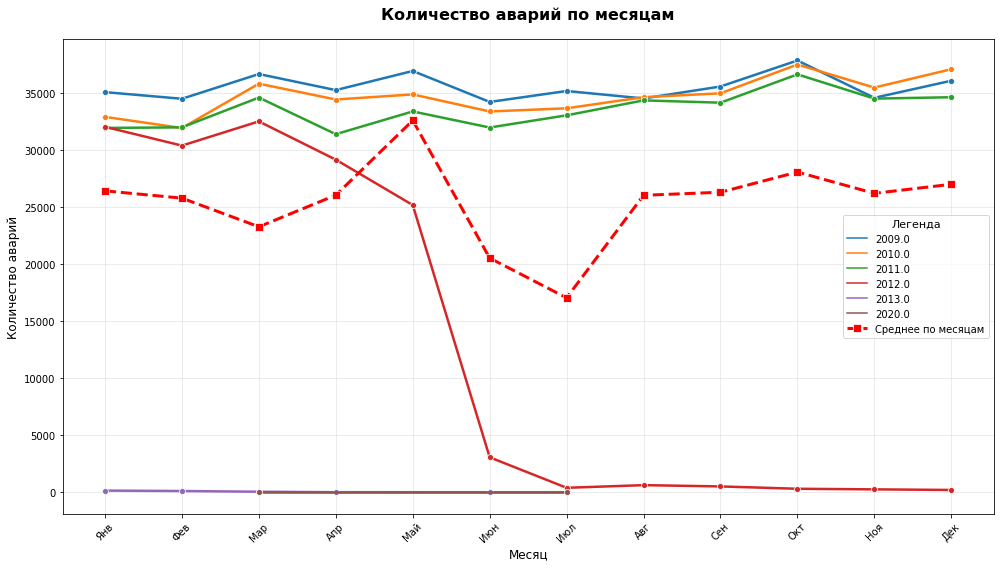

In [28]:
# Использование функции
df_result = plot_accidents_by_month_seaborn(engine, query)

График демонстрирует, что в базе данных есть данные за 2009-2012 гг, но 2012 год не полный. Вероятно в 2012 году примерно с апреля стали постепенно завершать сбор данных. В таком случае для решения задачи возьмем все полные года и повторим построение графика.

In [29]:
query = '''
            SELECT 
                EXTRACT(YEAR FROM collision_date) as year,
                EXTRACT(MONTH FROM collision_date) as month,
                COUNT(case_id) as accident_count
            FROM collisions
            WHERE collision_date IS NOT NULL AND EXTRACT(YEAR FROM collision_date) < 2012
            GROUP BY EXTRACT(YEAR FROM collision_date), EXTRACT(MONTH FROM collision_date)
            ORDER BY year, month
        '''

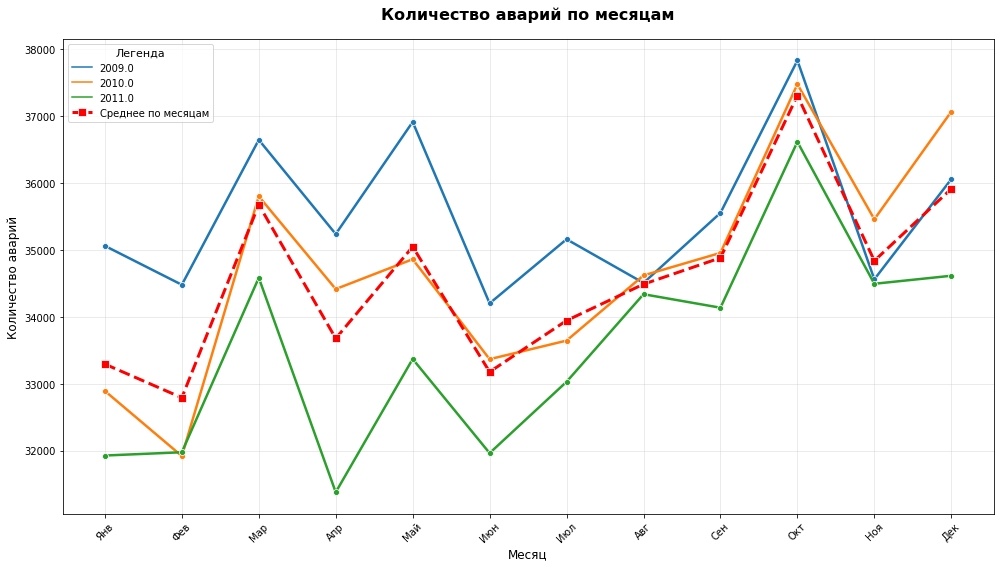

In [30]:
# Использование функции
df_result = plot_accidents_by_month_seaborn(engine, query)

В среднем на графике наблюдается небольшой рост количества аварий с начала года и до конца. Разница между январем и декабрем примерно 10%.


**Вывод** — наибольшее количество аварий происходит в конце года, если смотреть имеющиеся данные, то самый богатый месяц на ДТП это октябрь со средним значением примерно 37300.

**Задача 3.2:** Создать 6 задач и решить 2 из них.

*Список из шести составленных аналитических задач*

1. Исследуйте, как возраст транспортного средства коррелирует с тяжестью повреждений при столкновении. (Связь таблиц: vehicles -> collisions).

2. Определите наиболее распространенные виды нарушений (PCF) в зависимости от погодных условий. (Связь таблиц: collisions -> parties).

3. Проанализируйте распределение ДТП по времени суток и типу освещения. (Таблица collisions, для связи с другими задачами).

4. Определите, существует ли связь между типом столкновения (type_of_collision) и тем, было ли ДТП перекрестком (intersection).

5. Проанализируйте, как время суток (collision_time) влияет на физическое состояние участников ДТП (party_sobriety). (Связь таблиц: collisions -> parties).

6. Исследуйте взаимосвязь между стоимостью страховки автомобиля (insurance_premium) и его возрастом (vehicle_age), а также типом (vehicle_type). (Связь таблиц: parties -> vehicles).

**Решение задачи №1:** Исследуйте, как возраст транспортного средства коррелирует с тяжестью повреждений при столкновении. (Связь таблиц: vehicles -> collisions).

In [31]:
# SQL-запрос
query = '''
            SELECT
            -- Создаем категории возраста автомобиля для более удобного анализа
            CASE
                WHEN v.vehicle_age < 3 THEN 'Новый (0-2 г.)'
                WHEN v.vehicle_age BETWEEN 3 AND 7 THEN 'Средний (3-7 л.)'
                WHEN v.vehicle_age BETWEEN 8 AND 15 THEN 'Старый (8-15 л.)'
                WHEN v.vehicle_age > 15 THEN 'Очень старый (15+ л.)'
                ELSE 'Не указан'
            END AS vehicle_age_group,
            c.collision_damage,
            COUNT(*) AS accident_count
            FROM
                vehicles v
            JOIN
                collisions c ON v.case_id = c.case_id
            WHERE
                v.vehicle_age IS NOT NULL
                AND c.collision_damage IS NOT NULL
            GROUP BY
                vehicle_age_group, c.collision_damage
            ORDER BY
                vehicle_age_group, accident_count DESC;
        '''

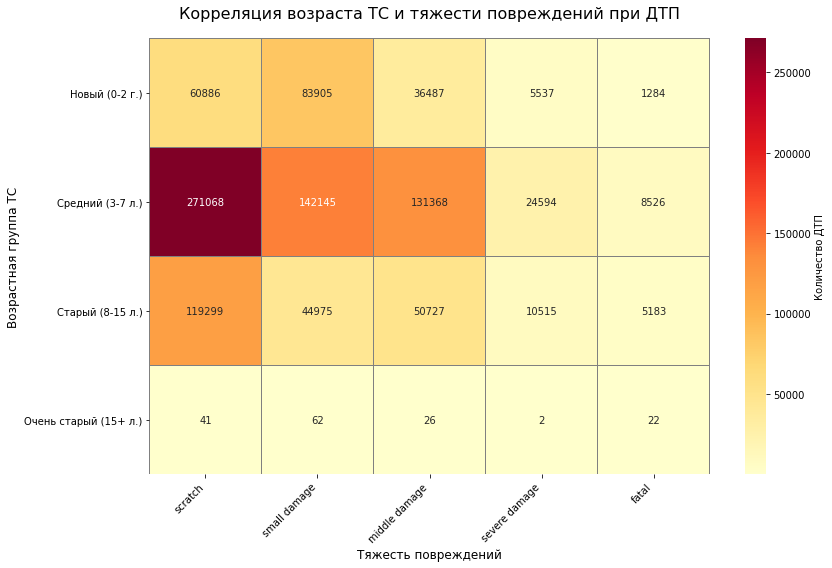

In [32]:
# Создаем датафрейм по результатам SQL-запроса
df = pd.read_sql_query(query, engine)

# Создаем сводную таблицу для heatmap
pivot_table = df.pivot_table(
    values='accident_count',
    index='vehicle_age_group',
    columns='collision_damage',
    aggfunc='sum',
    fill_value=0
)

# Определяем порядок категорий для осей (для лучшей читаемости)
age_order = ['Новый (0-2 г.)', 'Средний (3-7 л.)', 'Старый (8-15 л.)', 'Очень старый (15+ л.)']
damage_order = ['scratch', 'small damage', 'middle damage', 'severe damage', 'fatal']

# Переиндексируем таблицу в нужном порядке
pivot_table = pivot_table.reindex(index=age_order, columns=damage_order)

# Создаем heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table,
    annot=True,           # Показывать числа в ячейках
    fmt='d',              # Формат чисел - целые
    cmap='YlOrRd',        # Цветовая схема (желтый-оранжевый-красный)
    linewidths=0.5,       # Ширина линий между ячейками
    linecolor='gray',     # Цвет линий между ячейками
    cbar_kws={'label': 'Количество ДТП'}  # Подпись для цветовой шкалы
)

# Настраиваем внешний вид графика
plt.title('Корреляция возраста ТС и тяжести повреждений при ДТП', fontsize=16, pad=20)
plt.xlabel('Тяжесть повреждений', fontsize=12)
plt.ylabel('Возрастная группа ТС', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Показываем график
plt.tight_layout()
plt.show()

Тепловая карта наглядно демонстрирует, что в датафрейме преимущественно ТС среднего возраста и они в ДТП получают в основном мелкие повреждения, при которых машина на ходу. Рассмотрим распределения доли машин в каждой возрастной категории по тяжести повреждения.

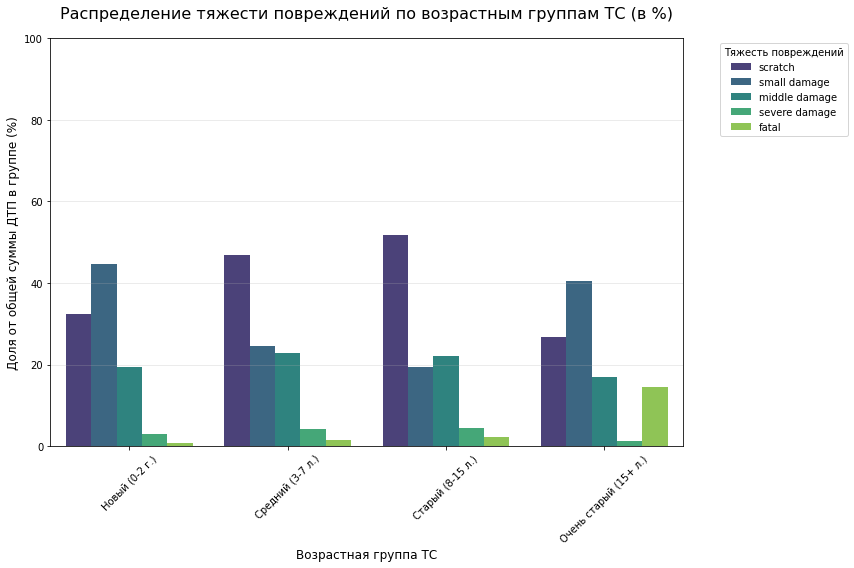

Распределение повреждений по возрастным группам (%):


collision_damage,scratch,small damage,middle damage,severe damage,fatal
vehicle_age_group,,,,,
Новый (0-2 г.),32.369125,44.606829,19.397764,2.943663,0.682619
Средний (3-7 л.),46.921851,24.605289,22.739791,4.257220,1.475850
Старый (8-15 л.),51.711971,19.495100,21.988392,4.557887,2.246650
Очень старый (15+ л.),26.797386,40.522876,16.993464,1.307190,14.379085


In [33]:
# Вычисляем доли для каждой возрастной группы
pivot_table_percentage = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Преобразуем обратно в длинный формат для seaborn
df_percentage = pivot_table_percentage.reset_index().melt(
    id_vars='vehicle_age_group',
    var_name='collision_damage',
    value_name='percentage'
)

# Создаем столбчатую диаграмму с накоплением в seaborn
plt.figure(figsize=(12, 8))

# Используем barplot с вычисленными долями
ax = sns.barplot(
    data=df_percentage,
    x='vehicle_age_group',
    y='percentage',
    hue='collision_damage',
    order=age_order,
    hue_order=damage_order,
    palette='viridis'
)

# Настраиваем внешний вид
plt.title('Распределение тяжести повреждений по возрастным группам ТС (в %)', fontsize=16, pad=20)
plt.xlabel('Возрастная группа ТС', fontsize=12)
plt.ylabel('Доля от общей суммы ДТП в группе (%)', fontsize=12)
plt.legend(title='Тяжесть повреждений', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Устанавливаем пределы оси Y для лучшего отображения
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# Дополнительно: выводим таблицу с процентами для справки
print("Распределение повреждений по возрастным группам (%):")
#pivot_table_percentage.round(1)
pivot_table_percentage.style.background_gradient(cmap='RdYlGn_r')

**Выводы по задаче №1**

Распределение степени тяжести повреждений ТС в ДТП по возрасту ТС неодназначное. Мы видим, что царапины занимают весомую долю во всех возрастах, при этом их доля увеличивается к старым машинам и падает на очень старых. У мелких повреждений абсолютно обратная ситуация: их доля уменьшается к старым машинам и потом возрастает на очень старых. Доля средних повреждений практически неизменна относительно других категорий повреждений и колеблется вблизи 20%. Доля серьезных повреждений относительно других незначительно увеличивается от новых к старым ТС и для очень старых ТС уменьшается. Доля фатальных повреждений сохраняет тенденцию серьезных повреждений вплоть до старых ТС, а вот для очень старых резко возрастает.

**Решение задачи №6:** Исследуйте взаимосвязь между стоимостью страховки автомобиля (insurance_premium) и его возрастом (vehicle_age), а также типом (vehicle_type). (Связь таблиц: parties -> vehicles).

In [34]:
# SQL-запрос для получения данных (без разделения по группам признака vehicle_age)
query = '''
            SELECT 
                v.vehicle_type,
                v.vehicle_age,
                p.insurance_premium
            FROM 
                parties p
            JOIN 
                vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number
            WHERE 
                p.insurance_premium IS NOT NULL 
                AND v.vehicle_age IS NOT NULL
                AND v.vehicle_type IS NOT NULL;
        '''

In [35]:
# Загружаем данные из базы
df = pd.read_sql_query(query, engine)

# Преобразуем типы данных
df['vehicle_age'] = pd.to_numeric(df['vehicle_age'], errors='coerce')
df['insurance_premium'] = pd.to_numeric(df['insurance_premium'], errors='coerce')

print(f"Всего записей: {len(df)}")
print(f"Уникальных типов автомобилей: {df['vehicle_type'].nunique()}")

Всего записей: 982863
Уникальных типов автомобилей: 5


Из исследования уникальных значний мы знаем, что признак `vehicle_age` является дискретным. Поэтому будем использовать boxplot и гистограмму

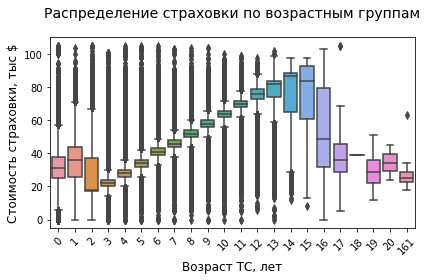

In [36]:
# График 1: Boxplot по возрасту ТС
sns.boxplot(data=df, x='vehicle_age', y='insurance_premium')
plt.title('Распределение страховки по возрастным группам', fontsize=14, pad=20)
plt.xlabel('Возраст ТС, лет', fontsize=12)
plt.ylabel('Стоимость страховки, тыс $', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Наблюдается аномальное значение — возраст ТС 161 год — удалим данную категорию

In [37]:
# фильтруем аномальные значения
df = df.query('vehicle_age<=20')

Выделяются четкие группы по возрасту ТС за счет характерных зависимостей:

1. 0-2 г — в одном диапазоне, примерно 20-40 тыс долларов
2. 3-14 г — стоимость растет от года к году и медианное значение достигает максимума при 14 лет
3. 15-17 — спад стоимости от года к году
4. 18+ — постоянная стоимость на уровне первой группы 20-40 тыс долларов

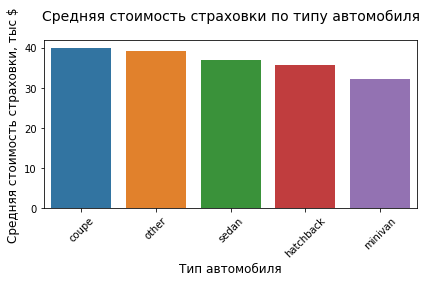

In [38]:
# График 2: Средняя страховка по типу автомобиля
avg_by_type = df.groupby('vehicle_type')['insurance_premium'].mean().sort_values(ascending=False)
sns.barplot(x=avg_by_type.index, y=avg_by_type.values)
plt.title('Средняя стоимость страховки по типу автомобиля', fontsize=14, pad=20)
plt.xlabel('Тип автомобиля', fontsize=12)
plt.ylabel('Средняя стоимость страховки, тыс $', fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Стоимость страховки в среднем зависит от типа кузова ТС: `coupe` имеет самую дорогую страховку, а `minivan` самую дешевую

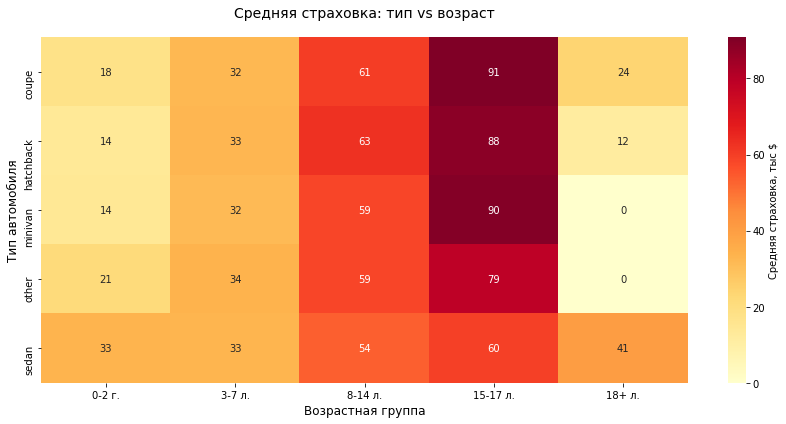

In [39]:
# Создаем возрастные группы с динамическими границами по результатам boxplot
max_age = df['vehicle_age'].max()
bins = [0, 2, 7, 14, 17, max_age + 1]
labels = ['0-2 г.', '3-7 л.', '8-14 л.', '15-17 л.', '18+ л.']
df['age_group'] = pd.cut(df['vehicle_age'], bins=bins, labels=labels)


# График 3: Heatmap - средняя страховка по типу и возрасту
plt.figure(figsize=(12, 6))

heatmap_data = df.pivot_table(values='insurance_premium', 
                                   index='vehicle_type', 
                                   columns='age_group', 
                                   aggfunc='mean',
                                   fill_value=0)

sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Средняя страховка, тыс $'})
plt.title('Средняя страховка: тип vs возраст', fontsize=14, pad=20)
plt.xlabel('Возрастная группа', fontsize=12)
plt.ylabel('Тип автомобиля', fontsize=12)

plt.tight_layout()
plt.show()

Мы наблюдаем, что самая дорогая страховка у `coupe` с возрастом 15-17 л. Самая дешевая, не считая нулевых значений, у `hatchback` с возрастом 18+ л

**Выводы по задаче №6:**

1. В данных аномальное значение возраста ТС — 161 год (исключен из анализа)
2. Выделяются четкие группы по возрасту ТС за счет характерных зависимостей
3. Стоимость страховки зависит от типа кузова ТС

## Создайте модель для оценки водительского риска

### Выгрузка таблицы

Составим SQL-запрос, где укажим только те признаки, которые можем узнать до ДТП, а также пропишем условия заказчика и условия возраста ТС. У каршеринговых компаний не может быть старых авто и за условное ограничение возьмем возраст ТС 10 лет.

In [40]:
# SQL-запрос для получения данных
query = '''
            SELECT
                p.at_fault, --целевой признак
                --признаки, значения которых можем узнать до ДТП:
                c.weather_1, 
                c.road_surface,
                c.lighting,
                c.county_city_location,
                c.direction,
                c.distance,
                c.road_condition_1,
                p.insurance_premium,
                p.cellphone_in_use,
                v.vehicle_type,
                v.vehicle_transmission,
                v.vehicle_age              
            FROM 
                parties p
            JOIN 
                vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number
            JOIN 
                collisions c ON p.case_id = c.case_id
            WHERE --условия заказчика:
                p.party_type = 'car'
                AND c.collision_damage != 'scratch'
                AND EXTRACT(YEAR FROM c.collision_date) = 2012
                AND v.vehicle_age <= 10
        '''

In [41]:
# сохраним датафрейм в переменной df
df = pd.read_sql_query(query, con=engine)
df.head(3)

,at_fault,weather_1,road_surface,lighting,county_city_location,direction,distance,road_condition_1,insurance_premium,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
0,0,cloudy,wet,daylight,1101,north,55.0,normal,20.0,0.0,sedan,auto,3
1,0,clear,dry,dark with street lights,0708,east,21.0,normal,54.0,0.0,sedan,manual,10
2,0,clear,dry,daylight,3607,west,150.0,None,27.0,NaN,sedan,auto,3


In [42]:
# сделаем копию датафрейма
df_result = df.copy()

### Предобработка данных

Проверим данные на наличие пропусков и дубликатов. Узнаем, корректный ли тип данных у каждого признака.

In [43]:
df_result.head()

,at_fault,weather_1,road_surface,lighting,county_city_location,direction,distance,road_condition_1,insurance_premium,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age
0,0,cloudy,wet,daylight,1101,north,55.0,normal,20.0,0.0,sedan,auto,3
1,0,clear,dry,dark with street lights,0708,east,21.0,normal,54.0,0.0,sedan,manual,10
2,0,clear,dry,daylight,3607,west,150.0,None,27.0,NaN,sedan,auto,3
3,0,clear,dry,daylight,1942,east,450.0,normal,52.0,0.0,sedan,auto,10
4,0,clear,dry,daylight,1953,None,0.0,normal,29.0,NaN,sedan,auto,8


In [44]:
# выведем общую информацию
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51413 entries, 0 to 51412
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              51413 non-null  int64  
 1   weather_1             51258 non-null  object 
 2   road_surface          51107 non-null  object 
 3   lighting              51267 non-null  object 
 4   county_city_location  51413 non-null  object 
 5   direction             39866 non-null  object 
 6   distance              51413 non-null  float64
 7   road_condition_1      51191 non-null  object 
 8   insurance_premium     51002 non-null  float64
 9   cellphone_in_use      47485 non-null  float64
 10  vehicle_type          51413 non-null  object 
 11  vehicle_transmission  50878 non-null  object 
 12  vehicle_age           51413 non-null  int64  
dtypes: float64(3), int64(2), object(8)
memory usage: 5.1+ MB


Наблюдаем, что пропуски есть в следующих признаках: `weather_1`, `road_surface`, `lighting`, `direction`, `road_condition_1`, `insurance_premium`, `cellphone_in_use`, `vehicle_transmission`. Тип данных каждого признака соответствует описанию за исключением `cellphone_in_use`. Тип данных в `cellphone_in_use` переведем `str` после заполнения пропусков.

Решим вопрос пропусков в датасете.

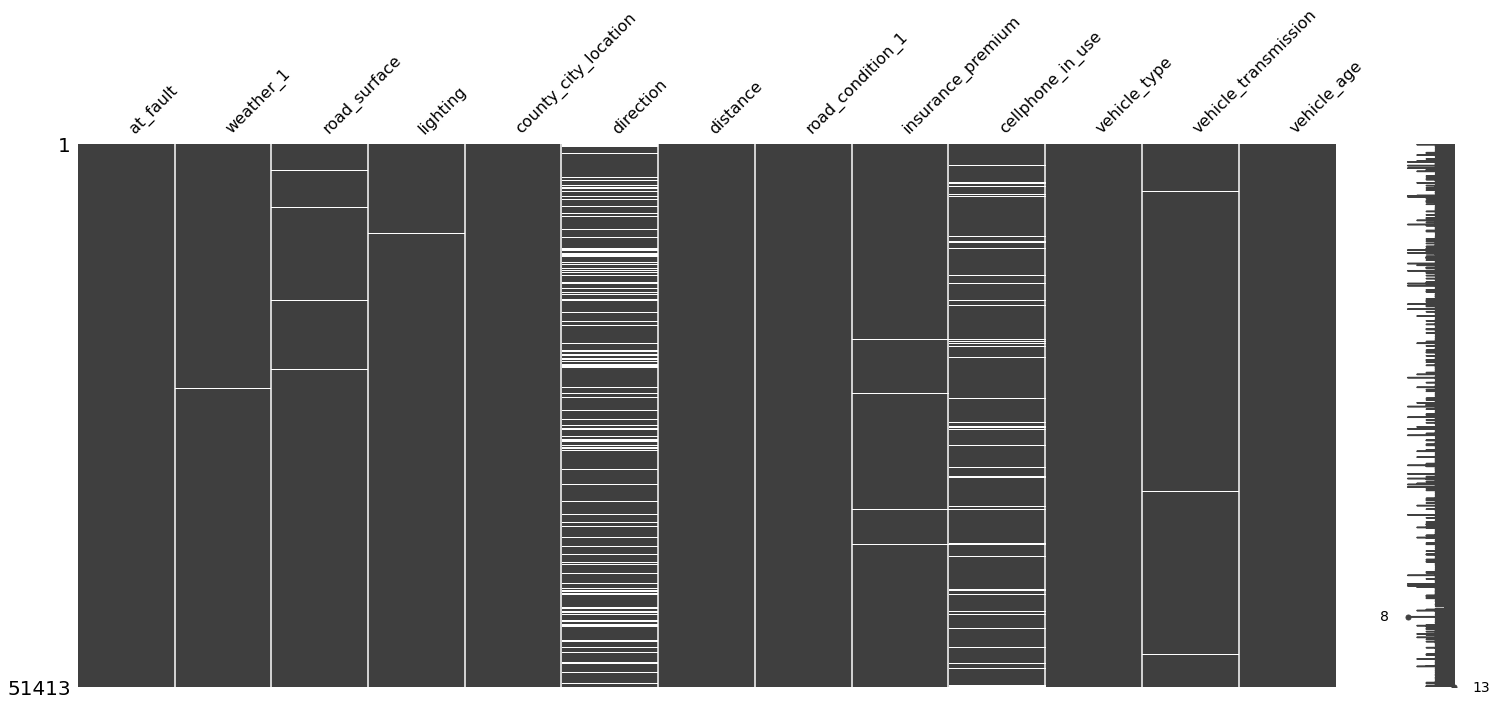

In [45]:
msno.matrix(df_result);

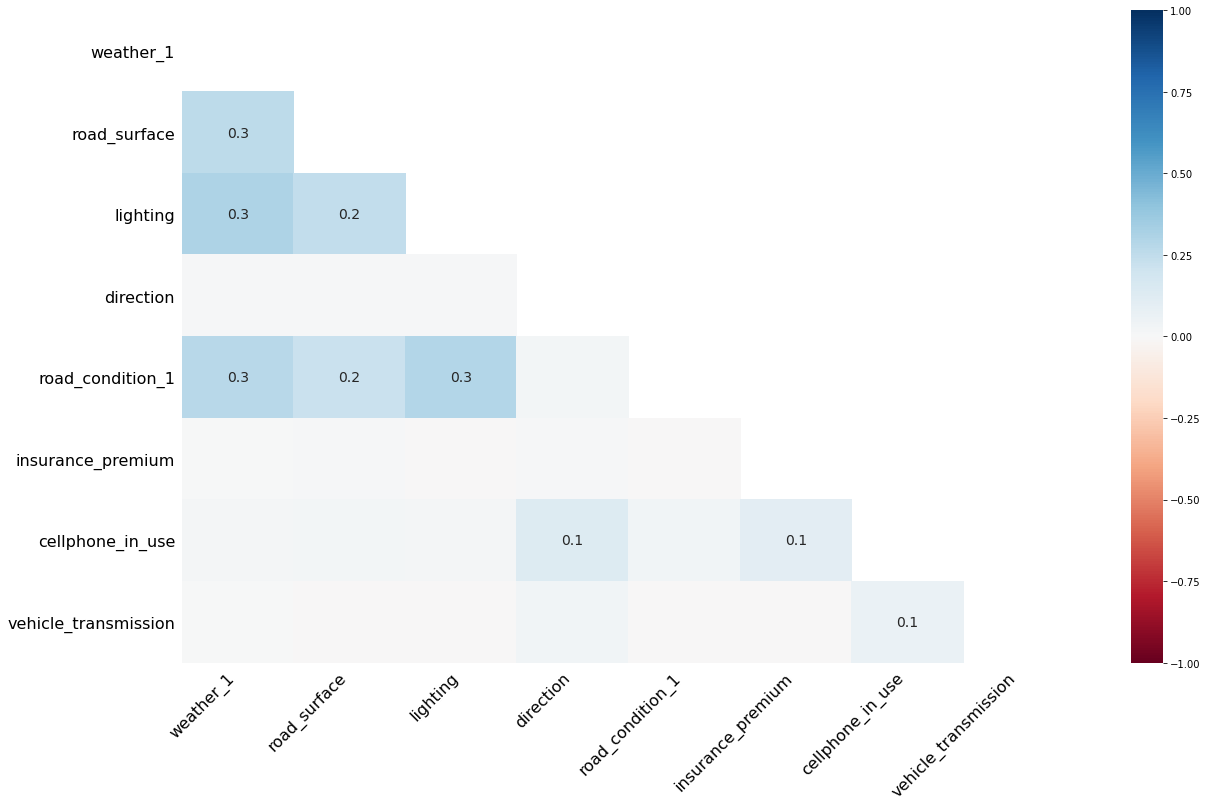

In [46]:
msno.heatmap(df_result);

In [47]:
df_result['weather_1'].unique()

array(['cloudy', 'clear', 'raining', 'fog', None, 'snowing', 'other',
       'wind'], dtype=object)

In [48]:
df_result['road_condition_1'].unique()

array(['normal', None, 'construction', 'reduced width', 'holes', 'other',
       'obstruction', 'flooded', 'loose material'], dtype=object)

У признаков `weather_1`, `road_condition_1` есть значение `other`, поэтому пропуски заполним данным значением.

In [49]:
df_result['road_surface'].unique()

array(['wet', 'dry', 'snowy', None, 'slippery'], dtype=object)

In [50]:
df_result['lighting'].unique()

array(['daylight', 'dark with street lights',
       'dark with no street lights', 'dusk or dawn', None,
       'dark with street lights not functioning'], dtype=object)

In [51]:
df_result['vehicle_transmission'].unique()

array(['auto', 'manual', None], dtype=object)

Признаки `road_surface`, `lighting`, `vehicle_transmission` имеют незначительное количество пропусков, но при этом значения предполагются важными для предсказания целевого признака. Поэтому удалим пропуски в даннных признаках.

Пропуски в признаке `insurance_premium` заменим медианным значением по типу кузова.

In [52]:
df_result['cellphone_in_use'].unique()

array([ 0., nan,  1.])

В признаке `ellphone_in_use` пропуск может означать, что такой системы в машине нет, поэтому заменим их на значение `0`.

In [53]:
df_result['direction'].unique()

array(['north', 'east', 'west', None, 'south'], dtype=object)

Пропусков в признаке `direction` уже значительное количество, поэтому вынесем их в отдельную категорию `other`.

Заполним или удалим пропуски в соответствии с текстом выше. 

In [54]:
df_result['weather_1'] = df_result['weather_1'].fillna('other')
df_result['road_condition_1'] = df_result['road_condition_1'].fillna('other')
df_result['direction'] = df_result['direction'].fillna('other')

df_result = df_result.dropna(subset=['road_surface', 'lighting', 'vehicle_transmission'])

df_result['cellphone_in_use'] = df_result['cellphone_in_use'].fillna(0)
df_result['cellphone_in_use'] = df_result['cellphone_in_use'].astype('str')

In [55]:
df_result['vehicle_type'].unique()

array(['sedan', 'coupe', 'other'], dtype=object)

In [56]:
df_result.query('vehicle_type=="sedan"')['insurance_premium'].median()

33.0

In [57]:
df_result.query('vehicle_type=="coupe"')['insurance_premium'].median()

33.0

In [58]:
df_result.query('vehicle_type=="other"')['insurance_premium'].median()

20.0

Получается, если заполнять пропуски в признаке `insurance_premium` по типу авто, то нужно два значения: 20 для `other` и 33 для остальных типов.

In [59]:
# Создаём маску: строки, где vehicle_type != 'other' И insurance_premium является NaN
mask = (df_result['vehicle_type'] != 'other') & (df_result['insurance_premium'].isna())

# Присваиваем 33.0 только тем ячейкам, которые удовлетворяют обоим условиям
df_result.loc[mask, 'insurance_premium'] = 33.0

In [60]:
mask_other = (df_result['vehicle_type'] == 'other') & (df_result['insurance_premium'].isna())
df_result.loc[mask_other, 'insurance_premium'] = 20.0

In [61]:
# выведем общую информацию
df_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50482 entries, 0 to 51412
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   at_fault              50482 non-null  int64  
 1   weather_1             50482 non-null  object 
 2   road_surface          50482 non-null  object 
 3   lighting              50482 non-null  object 
 4   county_city_location  50482 non-null  object 
 5   direction             50482 non-null  object 
 6   distance              50482 non-null  float64
 7   road_condition_1      50482 non-null  object 
 8   insurance_premium     50482 non-null  float64
 9   cellphone_in_use      50482 non-null  object 
 10  vehicle_type          50482 non-null  object 
 11  vehicle_transmission  50482 non-null  object 
 12  vehicle_age           50482 non-null  int64  
dtypes: float64(2), int64(2), object(9)
memory usage: 5.4+ MB


Пропуски и тип данных обработаны. Проанализируем дубликаты.

In [62]:
# выведем количество явных дубликатов
df_result.duplicated().sum()

738

Явных дубликатов незначительное количество, при этом их наличие возможно, так как это означает, что в разных ДТП машины и место по определенным характеристикам соответственно идентичны. Проверка на неявные дубликаты уже проведена, когда были рассмотрены уникальные значения категориальных признаков - они действительно уникальны - поэтому неявные дубликаты отсутствуют. 

**Промежуточные выводы по предобработке данных**

1. Пропуски в датасетах обработаны.
2. Явные дубликаты имеют место быть и нет основания для их удаления, неявные дубликаты отсутствуют.
3. Тип данных соответствует описанию, за исключением столбца `cellphone_in_use`. Его тип данных переведен в строковый.          

### Числовое описание данных

Исследуем числовое описание данных с помощью составленной функции `extended_describe`

In [63]:
print(extended_describe.__doc__)


    Возвращает расширенное описание датафрейма в виде HTML-таблицы.

    Добавляет полезные метрики к стандартному описанию:
    - mismatch%: отклонение среднего (mean) от медианы (50%) в процентах
    - rel_std%: относительное стандартное отклонение в процентах (std / mean * 100)
    - cat_top_ratio%: доля самого частого значения в категориальных столбцах (freq / count * 100)

    Параметры:
    ----------
    df : pd.DataFrame
        Входной датафрейм для анализа.
    name : str, optional (default="DataFrame")
        Название датафрейма, отображается в заголовке вывода.

    Возвращает:
    -----------
    None
        Результат выводится в виде HTML-таблицы в интерфейсе (например, Jupyter Notebook).

    Пример использования:
    ---------------------
    >>> extended_describe(messages_df, name="messages_df")

    Числовое описание данных: messages_df
    +--------------+--------+--------+----------+-------------+----------------+----------------+
    |              | count  | un

In [64]:
# выведем числовое описание targetdf_result_df
extended_describe(df_result, name="df_result")

Числовое описание данных: df_result


,count,unique,top,freq,mean,std,min,25%,50%,75%,max,mismatch%,rel_std%,cat_top_ratio%
at_fault,50482.0,NaN,NaN,NaN,0.505309,0.499977,0.0,0.0,1.0,1.0,1.0,-49.469118,98.944793,NaN
weather_1,50482,7,clear,40442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.111723
road_surface,50482,4,dry,45297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.729012
lighting,50482,5,daylight,33806,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.966443
county_city_location,50482,491,1942,6336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.551008
direction,50482,5,other,11237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.259419
distance,50482.0,NaN,NaN,NaN,880.203126,7591.531974,0.0,10.0,150.0,600.0,1584000.0,486.802084,862.475007,NaN
road_condition_1,50482,8,normal,48677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.424468
insurance_premium,50482.0,NaN,NaN,NaN,35.677945,14.267541,0.0,23.0,33.0,46.0,105.0,8.114984,39.989807,NaN
cellphone_in_use,50482,2,0.0,49527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.108237


**Промежуточные выводы по числовому описанию:**

1. Целевой признак сбалансирован, так как среднее значение 0.51, что близко к 0.50
2. Погода преимущественно `clear`, поверхность дороги преимущественно `dry`, освещение преимущественно `daylight`, состояние дороги преимущественно `normal`, то есть условия преимущественно благоприятные
3. Направление движения преимущественно `other`
4. Для числового признака `distance` среднее значение сильно отличается от медианного, что указывает на наличие аномально больших значений и несимметричное распределение
5. Признак `insurance_premium` имеет близкие среднее и медианное значения, что указывает на равномерность данных
6. Машины преимущественно типа `sedan`, с ручной коробкой передач, без системы `cellphone_in_use`
7. Признак `vehicle_age` имеет близкие среднее и медианное значения, что указывает на равномерность данных
8. При этому числовые признаки имеют большие значения `rel_std%`, что указывает на широкий разброс данных и благоприятно скажется на предсказательной способности модели.

### Исследовательский анализ

In [65]:
df_result['at_fault'] = df_result['at_fault'].astype('str') 

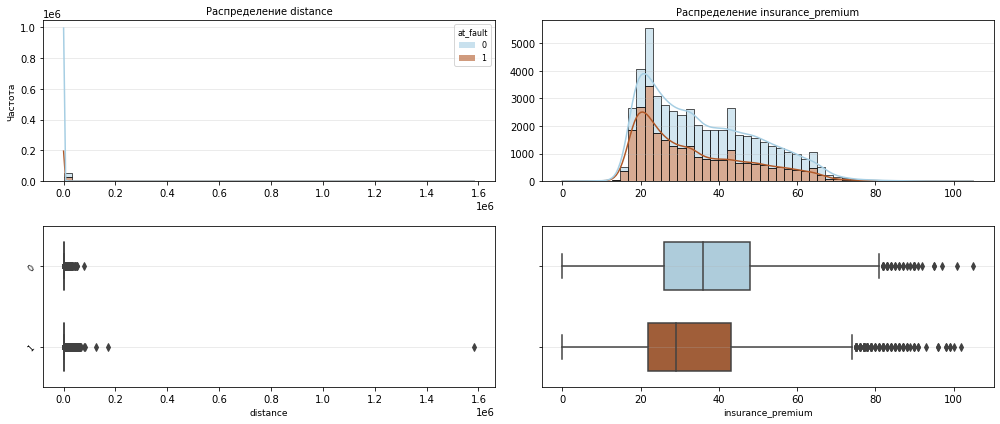

In [66]:
# выберем непрерывные числовые признаки
features = [
    ('distance', 'distance'),
    ('insurance_premium', 'insurance_premium')
    #('vehicle_age', 'vehicle_age')
    ]

plot_distribution_with_boxplot(
    df_result,
    features,
    'at_fault',
    #auto_bins=True,
    bins=50,
    log_scale='auto',
)

Видно, что в признаке `distance` есть одно на порядок отличающееся значение, что можно отнести к исключениям и удалить, чтобы не вводить в заблуждение модель

In [67]:
df_result = df_result[df_result['distance'] != df_result['distance'].max()] 

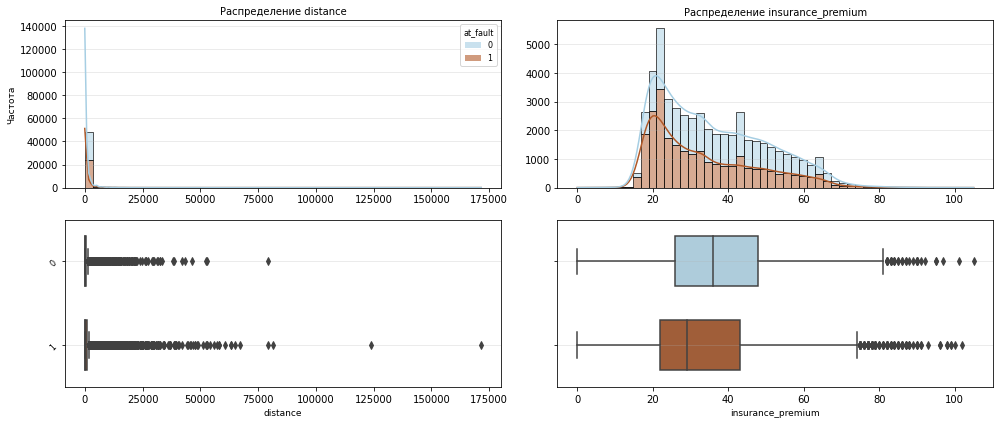

In [68]:
# выберем непрерывные числовые признаки
features = [
    ('distance', 'distance'),
    ('insurance_premium', 'insurance_premium')
    #('vehicle_age', 'vehicle_age')
    ]

plot_distribution_with_boxplot(
    df_result,
    features,
    'at_fault',
    #auto_bins=True,
    bins=50,
    log_scale='auto'
)

`insurance_premium` имеет преимущественно меньшее значение для виновников ДТП. Максимальное расстоние от главной дороги у виновников ДТП больше.  

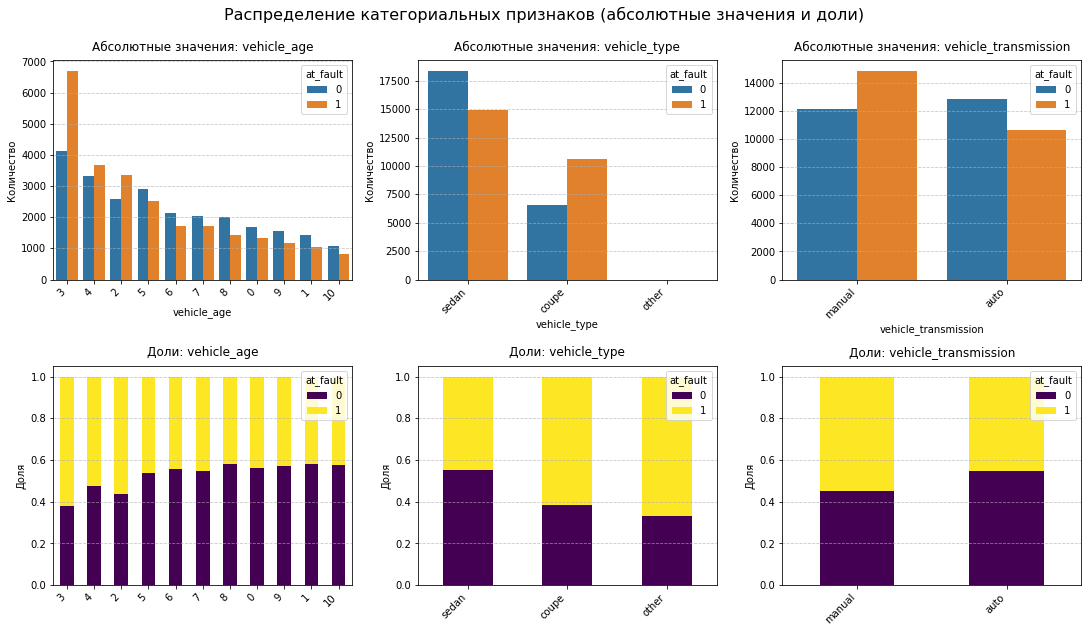

CPU times: user 3.61 s, sys: 191 ms, total: 3.8 s
Wall time: 3.82 s


In [69]:
%%time
# выберем дискретные числовые признаки и категориальные
features = [
    'vehicle_age',
    'vehicle_type',
    'vehicle_transmission'
    ]

plot_categorical_distributions(
    df_result,
    'at_fault',
    features,
    log_scale=False,
    ncols=3,
    max_categories=20,
    annotation_pos='above_title'
)

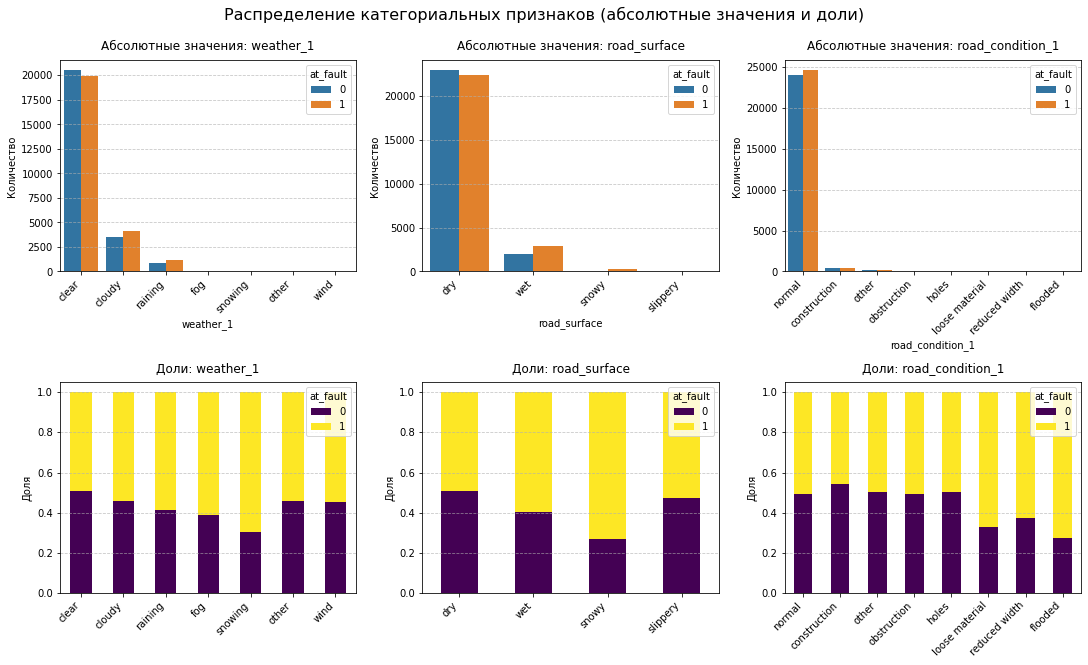

CPU times: user 3.64 s, sys: 175 ms, total: 3.81 s
Wall time: 3.83 s


In [70]:
%%time
# выберем дискретные числовые признаки и категориальные
features = [
    'weather_1',
    'road_surface',
    'road_condition_1'
    ]

plot_categorical_distributions(
    df_result,
    'at_fault',
    features,
    log_scale=False,
    ncols=3,
    max_categories=20,
    annotation_pos='above_title'
)

Виновники ДТП преимущественно ездят на более новых авто 2-4 года, типа `coupe`, с ручной коробкой передач. Виновниками ДТП преимущественно становятся при снежной погоде, и заснеженной поверхности дороги, когда дорога затоплена, уменьшенная ширина проезжой части, сыпучий материал на дороге. В большинстве логически важных признаках сильный дисбаланс, который можно учесть при разделении на выборки.

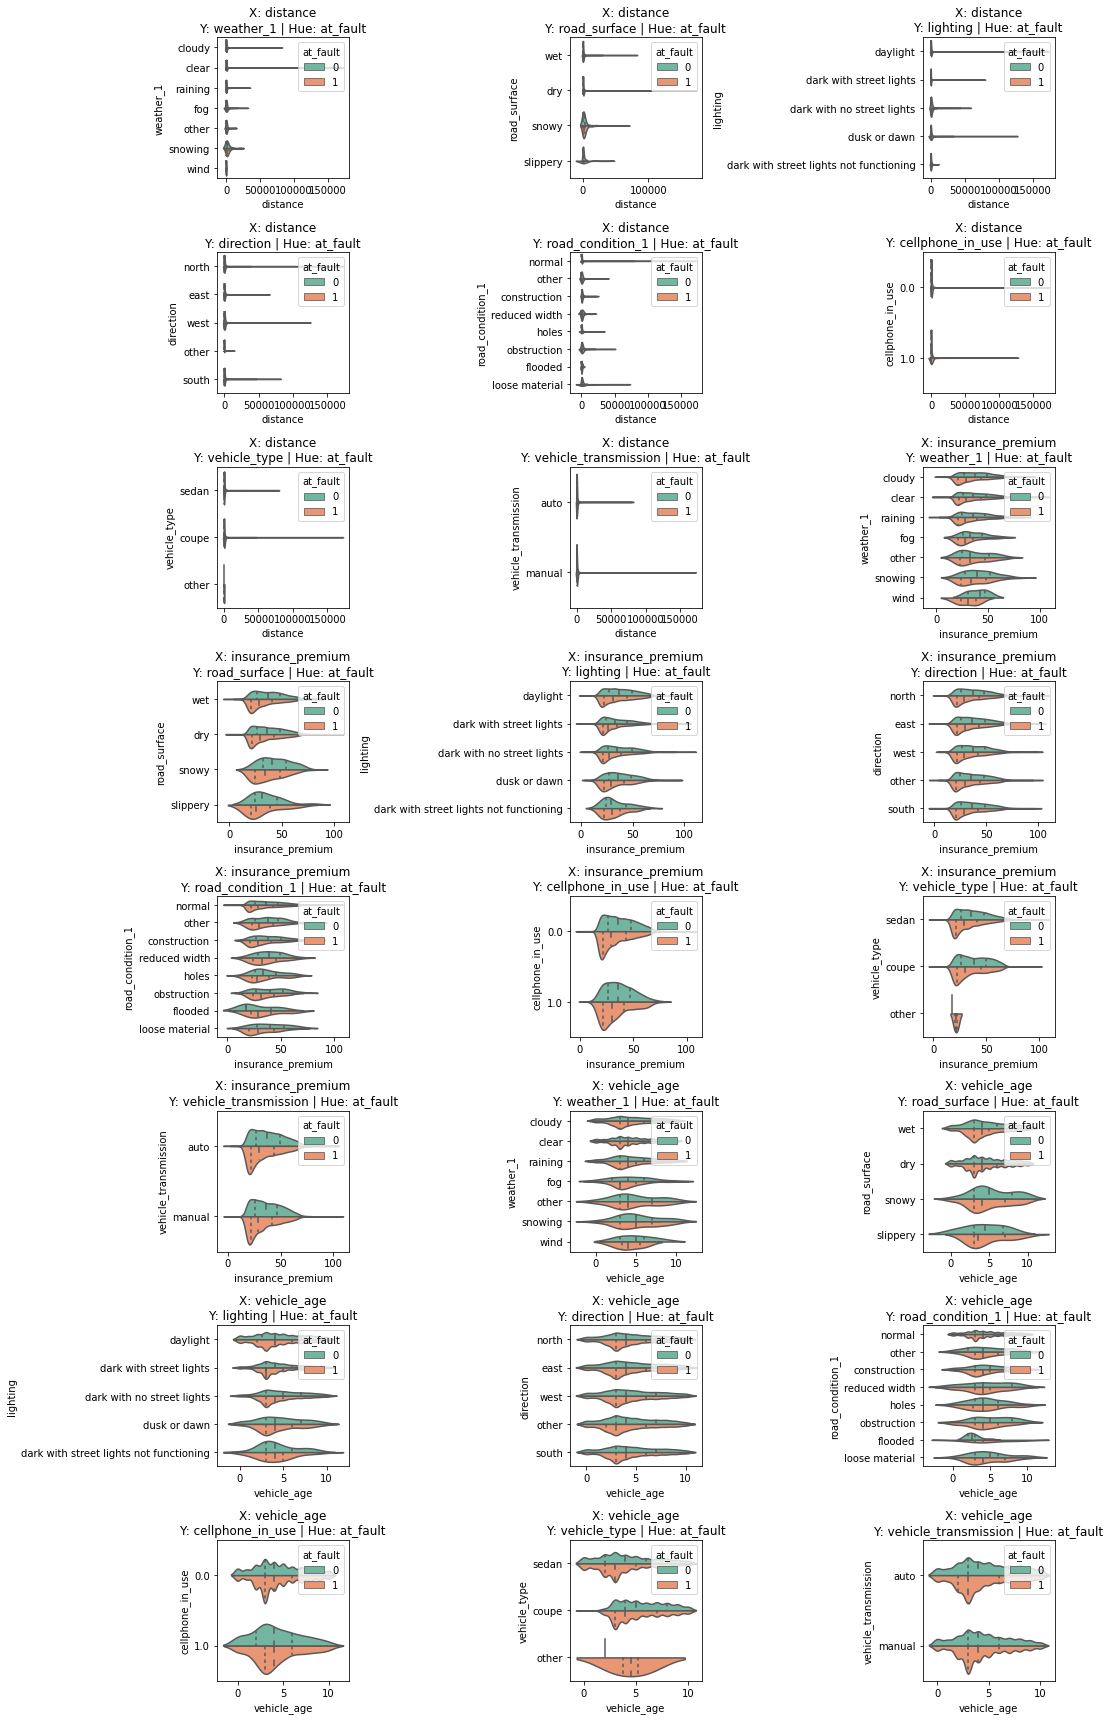

In [71]:
plot_violin_combinations(
    df_result,
    x_column=[
        'distance',
        'insurance_premium',
        'vehicle_age'
    ],
    hue_features=['at_fault'],
    figsize_per_plot=(5, 3)
    #log_scale_x=False
)

Данное разнообразие графиков указывает на наличие некоторых различий в признаках между виновником и не виновником ДТП и указывает на важность входных признаков для предсказательной способности модели

**Промежуточные выводы на основе исследовтельского анализа**

Все входные признаки вносят некоторый вклад в различия между виновником и не виновником. Выявленные закономерности:
1. `insurance_premium` имеет преимущественно меньшее значение для виновников ДТП. Максимальное расстоние от главной дороги у виновников ДТП больше.
2. Виновники ДТП преимущественно ездят на более новых авто, типа `coupe`, с ручной коробкой передач.
3. Виновниками ДТП преимущественно становятся при снежной погоде, и заснеженной поверхности дороги, когда дорога затоплена, уменьшенная ширина проезжой части, сыпучий материал на дороге.
4. В большинстве логически важных признаках сильный дисбаланс, который можно учесть при разделении на выборки.

### Корреляционный анализ

CPU times: user 6.14 s, sys: 759 ms, total: 6.9 s
Wall time: 6.93 s


Text(0.5, 1.0, 'Зависимости для признаков по типу виновности')

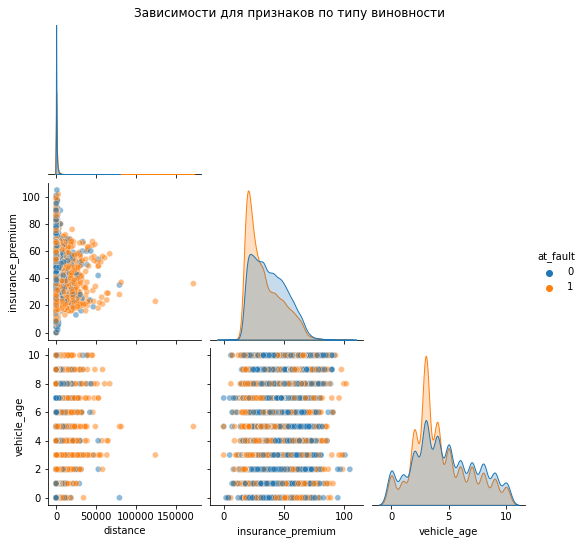

In [72]:
%%time
sns.pairplot(
    data=df_result,
    hue='at_fault',        # группировка по классам
    corner=True,         # не рисуем дублирующие графики
    plot_kws={'alpha': 0.5}
).fig.suptitle(
    'Зависимости для признаков по типу виновности',
    y=1.0
);

Матрица рассеяния не дает новой информации

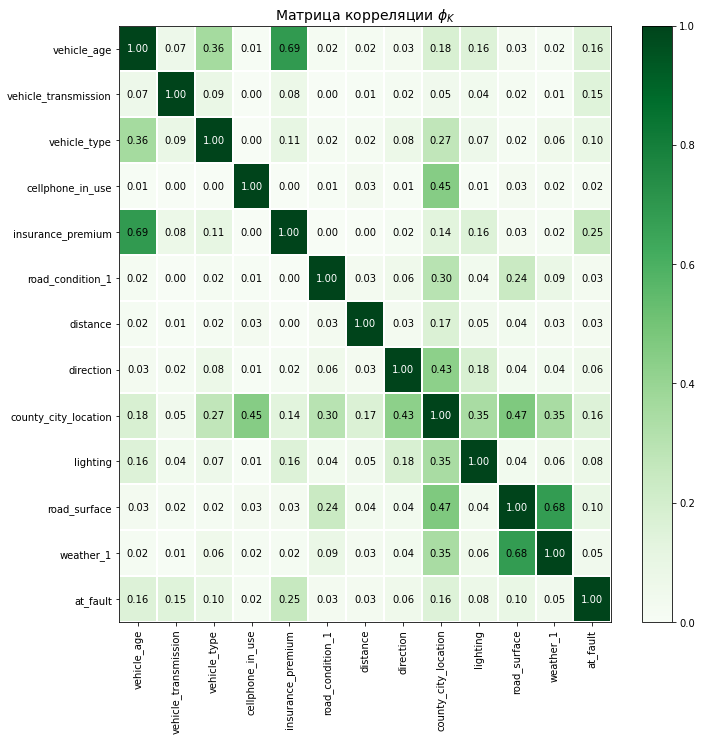

Мультиколлинеарность между парами входных признаков отсутствует
CPU times: user 7.31 s, sys: 261 ms, total: 7.57 s
Wall time: 7.6 s


In [73]:
%%time
# рассчитаем матрицу корреляции Phik
# присвоем переменной correlated_pairs датафрейм с парами признаков и их корреляцией Фи, превышающей порог
# присвоем переменной threshold пороговое значение
# присвоем переменной interval_cols список названий всех столбцов с числовым непрерывным типом данных в обрабатываемом датафрейме
# присвоем переменной phi_k_with_target корреляции признаков с целевой переменной
result = phik_correlation_matrix(
    df_result,
    threshold = 0.9,
    output_interval_cols=True,
    interval_cols=[
        'distance',
        'insurance_premium'
    ],
    target_col='at_fault',
    cell_size=0.8
)

# Результаты:
correlated_pairs = result[0]  # Пары коррелирующих признаков
interval_cols = result[1]     # Список числовых непрерывных столбцов
phi_k_with_target = result[2] # Корреляции признаков с целевой переменной

Мультиколлинеарность между входными признаками отсутствует, при этом все признаки имеют некоторую корреляцию с целевым. Максимальная корреляция целевого признака с `insurance_premium`, а минимальная с `cellphone_in_use`.

**Коэффициент инфляции дисперсии (variance inflation factor — VIF)** измеряет насколько сильно дисперсия коэффициента регрессии увеличивается из-за мультиколлинеарности (корреляции с другими признаками). Различают следующие категории мультиколлинеарности по значению VIF:
- вблизи 1 — отсутствует или пренебрежимо слабая;
- больше 5–10 — умеренная или сильная (требует внимания);
- больше 100 — критическая (модель ненадежная).

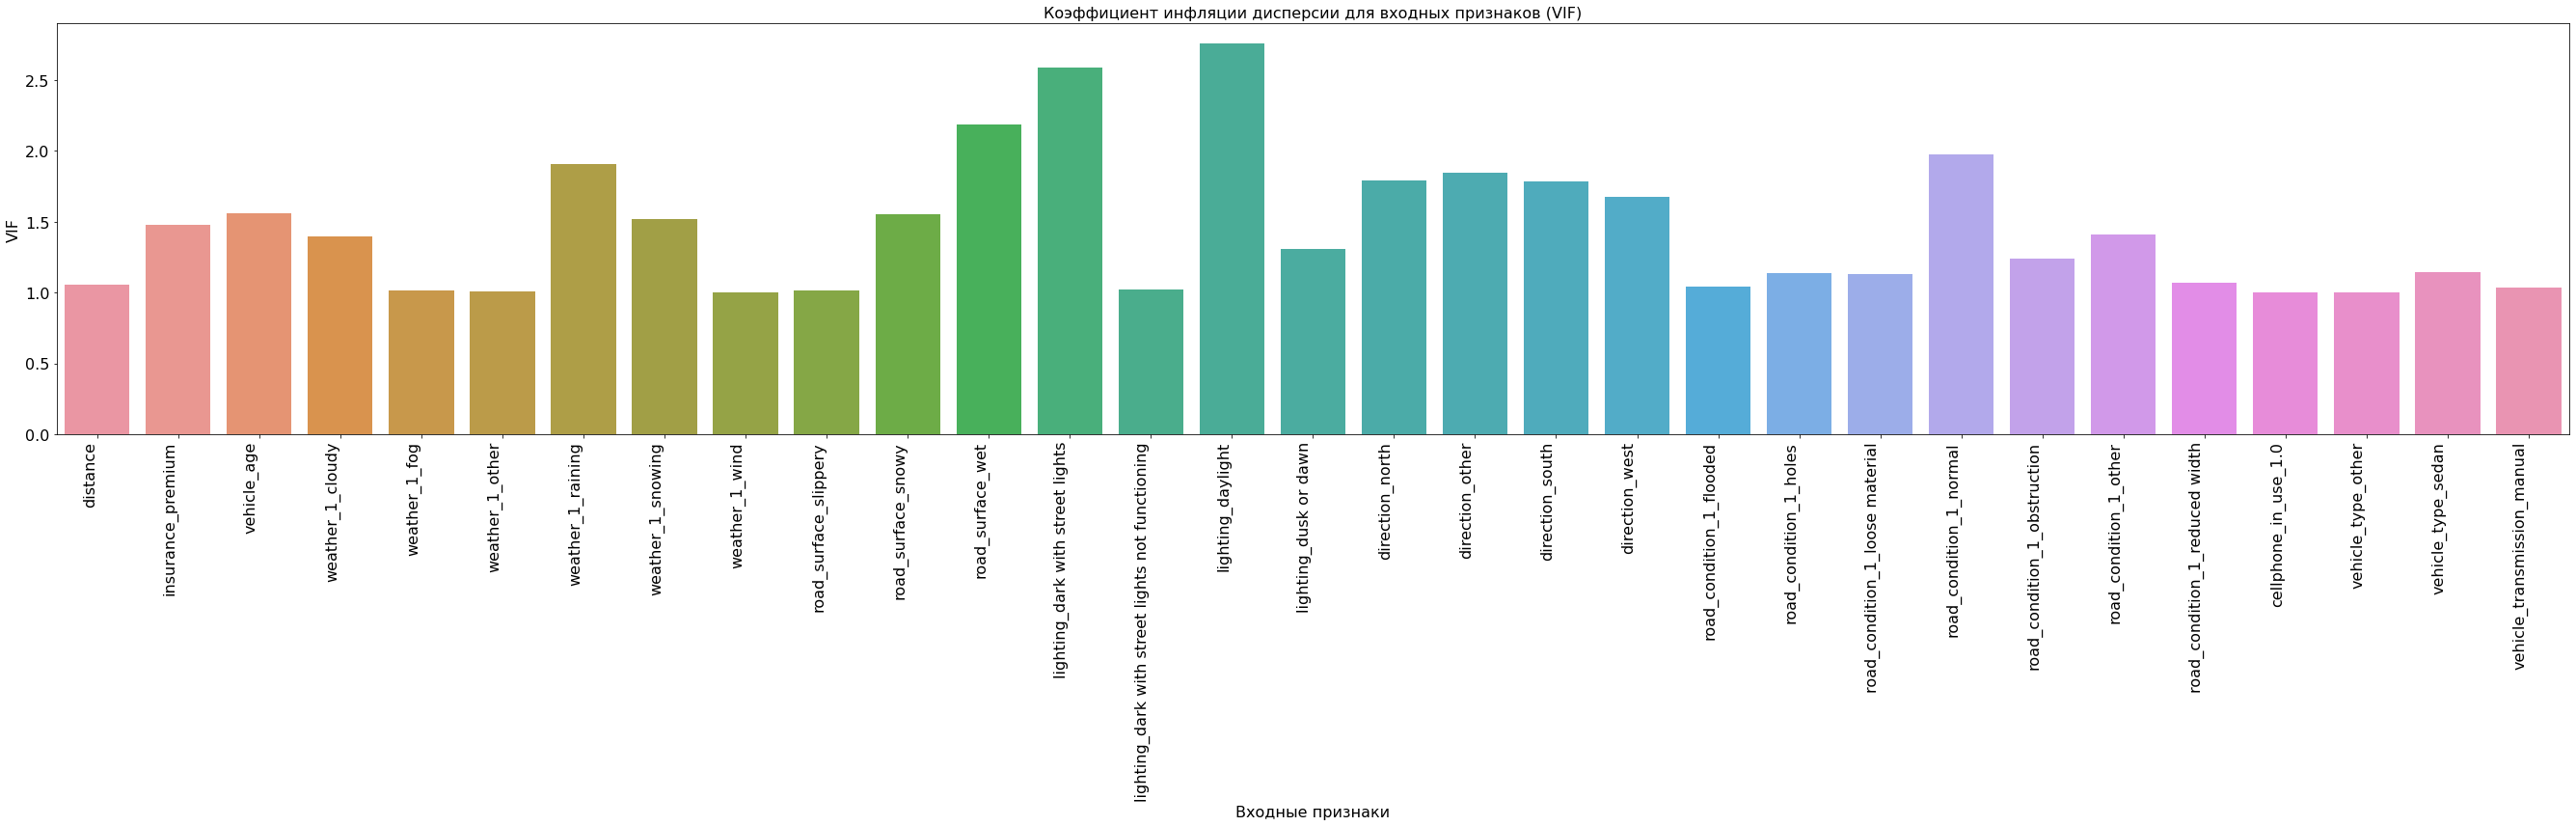

CPU times: user 12.5 s, sys: 8.71 s, total: 21.2 s
Wall time: 21.3 s


In [74]:
%%time
# используем составленную функцию расчета VIF
vif(df_result.drop(['at_fault', 'county_city_location'], axis=1), font_size=16)

Мультиколлинеарность отсутствует для всех признаков не только парная, но и в совакупности со всеми признаками 

**Промежуточные выводы на основе корреляционного анализа**

Присутствует некоторая корреляция целевого признака со всеми признаками, при этому максимальная корреляция с `insurance_premium`, а минимальная с `cellphone_in_use`. Мультиколлинеарность отсутствует для всех признаков не только парная, но и в совакупности со всеми признаками. Поэтому не один из признаков не является избыточным

### Подготовка обучающей и тестовой выборок, выбор метрики

При исследовательском анализе установлено, что целевой признак сбалансирован, а некоторые логически важные признаки имеют дисбаланс классов, поэтому создадим новый столбец для стратификации по важным признакам. Однако все такие признаки учесть не получилось в виду невозможности разделить на выборки. Оставим максимальный набор для разделения на выборки с максимальным значением корреляции с целевым признаком.   

In [75]:
# Сохраняем stratify_key до разбиения
df_result['stratify_key'] = (
    df_result['weather_1'].astype(str) + '_' +
    df_result['road_surface'].astype(str)
)

In [76]:
# Разделение данных на признаки и целевую переменную
X = df_result.drop('at_fault', axis=1)
y = df_result['at_fault']

# Разбиваем данные на обучающую и тестовую выборки с сохранением соотношений категорий признака Star color
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=X['stratify_key']
)

# Удаляем stratify_key
for df in [X_train, X_test, df_result]:
    df.drop(columns=['stratify_key'], inplace=True)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [77]:
# используем LabelEncoder для кодирования целевого признака
# инициализируем LabelEncoder
le = LabelEncoder()
# обучаем LabelEncoder на тренировочной выборке
y_train = le.fit_transform(y_train)
# кодируем целевой признак тестовой выборки
y_test = le.transform(y_test)

In [78]:
# Выведем исходные классы в порядке их кодирования
print(le.classes_)

['0' '1']


**Выбор метрики для оценки модели**

Поскольку целевой признак сбалансирован, то важность классификации виновника и не виновника можно считать одинаковой. Так как мы не знаем ошибка в определении какого класса приносит больший убыток, то в качестве метрики выберем F1-score, которая является гармоническим средним между Recall и Precision.

In [79]:
# Списки признаков для разных типов обработки
binary_features = ['cellphone_in_use', 'vehicle_transmission']  # Бинарные признаки
ohe_features = ['vehicle_type', 'road_surface']  # Признаки для One-Hot Encoding
catboost_features = ['weather_1', 'lighting', 'direction', 'road_condition_1', 'county_city_location']  # Признаки для CatBoostEncoder
numeric_features = ['distance', 'insurance_premium', 'vehicle_age']  # Числовые признаки

### Обучение моделей

#### LogisticRegression

In [80]:
%%time
randomized_search_lr, training_time_lr = main(
    X_train, y_train,
    model=LogisticRegression(random_state=RANDOM_STATE, max_iter=5000),  
    n_splits=3,
    n_iter=10,
    param_grid={
        'classifier__penalty': ['elasticnet'],  
        'classifier__C': [0.005, 0.01, 0.05], 
        'classifier__solver': ['saga'],
        'classifier__l1_ratio': [0.05, 0.1, 0.5],
        'feature_union__preprocessor__numeric__scaler': [StandardScaler(), MinMaxScaler(), None],
        'feature_union__catboost_pipe__catboost__sigma': [None, 0.5, 1.0, 2.0],
        'feature_union__catboost_pipe__catboost__a': [5.0, 10.0, 15.0]
    }
)

Mean training time per model: 6.56 seconds
Best parameters: {'feature_union__preprocessor__numeric__scaler': StandardScaler(), 'feature_union__catboost_pipe__catboost__sigma': 2.0, 'feature_union__catboost_pipe__catboost__a': 5.0, 'classifier__solver': 'saga', 'classifier__penalty': 'elasticnet', 'classifier__l1_ratio': 0.05, 'classifier__C': 0.005}
Best F1-score (CV): 0.6145771509207965
CPU times: user 3min 37s, sys: 4.45 s, total: 3min 42s
Wall time: 3min 43s


In [81]:
best_model_lr = randomized_search_lr.best_estimator_  # Лучшая модель
best_params_lr = randomized_search_lr.best_params_    # Лучшие параметры
best_score_lr = randomized_search_lr.best_score_      # Лучшее значение метрики F1

#### DecisionTreeClassifier

In [82]:
%%time
randomized_search_dt, training_time_dt = main(
    X_train, y_train,
    model=DecisionTreeClassifier(random_state=RANDOM_STATE),
    n_splits=3,
    n_iter=10,
    param_grid={
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__splitter': ['best', 'random'],
        'classifier__max_depth': [None, 3, 5, 10, 20],
        'classifier__min_samples_split': [3, 5, 10, 15],
        'classifier__min_samples_leaf': [2, 4, 6, 8, 10],
        'classifier__max_features': [None, 'sqrt', 'log2'],
        'classifier__class_weight': [None, 'balanced'],
        'feature_union__preprocessor__numeric__scaler': [StandardScaler(), MinMaxScaler(), None],
        'feature_union__catboost_pipe__catboost__sigma': [None, 0.05, 0.1, 0.5, 1.0],
        'feature_union__catboost_pipe__catboost__a': [0.5, 1.0, 5.0, 10.0, 15.0, 20.0]
    }
)

Mean training time per model: 0.82 seconds
Best parameters: {'feature_union__preprocessor__numeric__scaler': MinMaxScaler(), 'feature_union__catboost_pipe__catboost__sigma': 0.1, 'feature_union__catboost_pipe__catboost__a': 20.0, 'classifier__splitter': 'random', 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 8, 'classifier__max_features': None, 'classifier__max_depth': 5, 'classifier__criterion': 'gini', 'classifier__class_weight': 'balanced'}
Best F1-score (CV): 0.6065744864332715
CPU times: user 39.7 s, sys: 0 ns, total: 39.7 s
Wall time: 39.9 s


In [83]:
best_model_dt = randomized_search_dt.best_estimator_  # Лучшая модель
best_params_dt = randomized_search_dt.best_params_    # Лучшие параметры
best_score_dt = randomized_search_dt.best_score_      # Лучшее значение метрики F1

#### CatBoostClassifier

In [84]:
%%time
randomized_search_cb, training_time_cb = main(
    X_train, y_train,
    model=CatBoostClassifier(random_state=RANDOM_STATE, verbose=0),
    n_splits=3,
    n_iter=10,
    param_grid={
        'classifier__iterations': [100, 200, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__depth': [4, 6, 8, 10],
        'classifier__l2_leaf_reg': [1, 3, 5, 10],
        'classifier__border_count': [32, 64, 128, 254],
        'classifier__random_strength': [1, 2, 3],
        'classifier__bagging_temperature': [0, 0.5, 1],
        'classifier__grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
        'feature_union__preprocessor__numeric__scaler': [StandardScaler(), MinMaxScaler(), None],
        'feature_union__catboost_pipe__catboost__sigma': [None, 0.01, 0.05, 0.1, 0.5, 1.0],
        'feature_union__catboost_pipe__catboost__a': [0.5, 1.0, 5.0, 10.0, 15.0, 20.0]
    }
)

Mean training time per model: 4.85 seconds
Best parameters: {'feature_union__preprocessor__numeric__scaler': MinMaxScaler(), 'feature_union__catboost_pipe__catboost__sigma': 0.1, 'feature_union__catboost_pipe__catboost__a': 5.0, 'classifier__random_strength': 2, 'classifier__learning_rate': 0.01, 'classifier__l2_leaf_reg': 10, 'classifier__iterations': 100, 'classifier__grow_policy': 'Depthwise', 'classifier__depth': 4, 'classifier__border_count': 128, 'classifier__bagging_temperature': 1}
Best F1-score (CV): 0.6266840077422847
CPU times: user 2min 31s, sys: 1.53 s, total: 2min 33s
Wall time: 2min 50s


In [85]:
best_model_cb = randomized_search_cb.best_estimator_  # Лучшая модель
best_params_cb = randomized_search_cb.best_params_    # Лучшие параметры
best_score_cb = randomized_search_cb.best_score_      # Лучшее значение метрики F1

#### Выбор лучшей модели

In [86]:
# Создаем данные для сравнения
comparison_data = {
    'Model': ['LogisticRegression', 'DecisionTreeClassifier', 'CatBoostClassifier'],
    'F1-score': [best_score_lr, best_score_dt, best_score_cb],
    'Training Time (seconds)': [training_time_lr, training_time_dt, training_time_cb]
}

# Создаем DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Добавляем столбец с отношением F1-score к времени обучения (эффективность)
comparison_df['F1/Time Ratio'] = comparison_df['F1-score'] / comparison_df['Training Time (seconds)']

# Сортируем по F1-score (по убыванию)
comparison_df_sorted = comparison_df.sort_values('F1-score', ascending=False)

# Форматируем числа для лучшего отображения
comparison_df_sorted['F1-score'] = comparison_df_sorted['F1-score'].map('{:.4f}'.format)
comparison_df_sorted['Training Time (seconds)'] = comparison_df_sorted['Training Time (seconds)'].map('{:.2f}'.format)
comparison_df_sorted['F1/Time Ratio'] = comparison_df_sorted['F1/Time Ratio'].map('{:.4f}'.format)

# Выводим результат
print("Сравнение моделей (отсортировано по F1-score):")
comparison_df_sorted

Сравнение моделей (отсортировано по F1-score):


,Model,F1-score,Training Time (seconds),F1/Time Ratio
2,CatBoostClassifier,0.6267,4.85,0.1293
0,LogisticRegression,0.6146,6.56,0.0937
1,DecisionTreeClassifier,0.6066,0.82,0.7377


**Промежуточный вывод по обучению моделей**

Получается по метрике F1-score на кросс-валидационной выборке лучшей оказалась модель `CatBoostClassifier`. Однако с учетом времени обучения метрика `F1/Time Ratio` лучшая у `DecisionTreeClassifier`. Поскольку в условиях задачи не было требований выбрать модель с меньшим временем обучения, то остановимся на модели `CatBoostClassifier`.

## Проведите анализ важности факторов ДТП

### Анализ матрицы ошибок

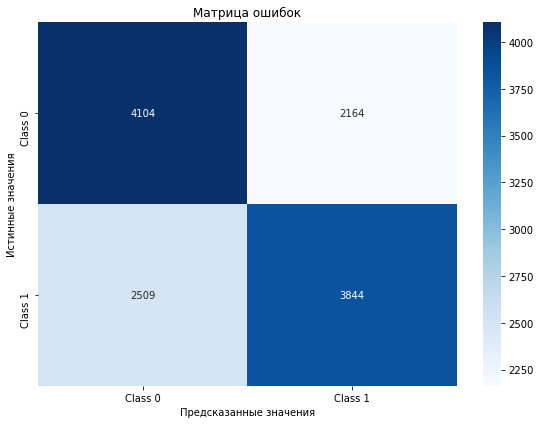


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.65      0.64      6268
           1       0.64      0.61      0.62      6353

    accuracy                           0.63     12621
   macro avg       0.63      0.63      0.63     12621
weighted avg       0.63      0.63      0.63     12621


Test ROC-AUC:
0.6695098095448277

F1-score on CV: 0.6267
F1-score on Test: 0.6267
Difference: 0.0000


In [87]:
# предсказания на тестовой выборке
y_pred = best_model_cb.predict(X_test)
y_pred_proba = best_model_cb.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса

# метрика ROC-AUC
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

# матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
# Визуализация
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.tight_layout()
plt.show()

# полный отчет о классификации
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nTest ROC-AUC:")
print(test_roc_auc)

# Сравнение с кросс-валидационными результатами
cv_f1 = randomized_search_cb.best_score_
print(f"\nF1-score on CV: {cv_f1:.4f}")
print(f"F1-score on Test: {best_score_cb:.4f}")
print(f"Difference: {abs(cv_f1 - best_score_cb):.4f}")

*ВАЖНО: при повторном обучении значения метрик могут незначительно отличаться, но на выводы это не повлияет*

*Ключевые наблюдения:*
- Высокое количество ошибок обоих типов: 2161 FP + 2540 FN = 4701 ошибок из 12621 предсказаний
- Сбалансированность классов: почти равное количество примеров каждого класса (6172 vs 6449)
- Сходство метрик: precision (0.64) ≈ recall (0.61) для обоих классов
- Стабильность: разница между CV и test F1-score (`Difference`) мала, что хорошо

*Детальный анализ по классам*
- Класс 0 (Негативный):
    - Точность: 61% - из всех предсказанных "0", 61% действительно "0"
    - Полнота: 65% - из всех реальных "0", 65% были правильно предсказаны
- Класс 1 (Позитивный):
    - Точность: 64% - из всех предсказанных "1", 64% действительно "1"
    - Полнота: 61% - из всех реальных "1", 61% были правильно предсказаны
    
*Проблемы и ограничения*
- Низкая дискриминационная способность: ROC-AUC = 0.67 указывает на слабую способность модели различать классы
- Систематические ошибки: высокое количество как ложноположительных, так и ложноотрицательных предсказаний

**Промежуточные выводы по матрице ошибок:**

1. Общая оценка качества — Модель показывает умеренное качество — F1-score ≈ 0.62, что указывает на среднюю эффективность классификации. Это лучше, чем случайное угадывание (0.5)
2. Возможные причины проблем — Недостаточно информативные признаки

### Анализ важности признаков

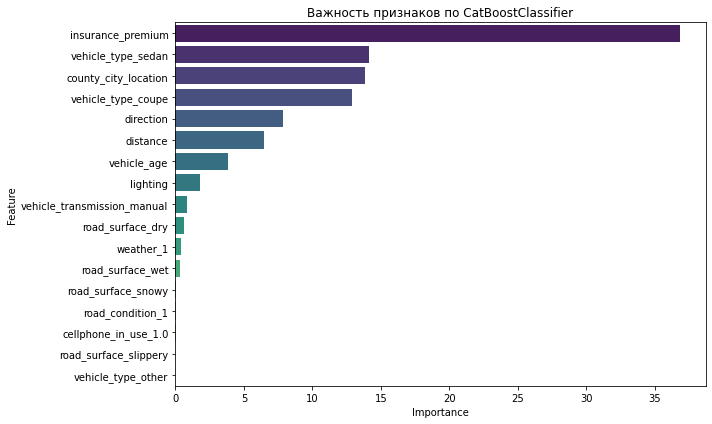

In [88]:
# Получаем лучшую модель из RandomizedSearchCV
best_pipeline = randomized_search_cb.best_estimator_

# Извлекаем CatBoostClassifier из пайплайна
catboost_model = best_pipeline.named_steps['classifier']

# Получаем важности признаков из модели
feature_importance = catboost_model.feature_importances_

# Получаем имена признаков из шага feature_union
feature_names = best_pipeline.named_steps['feature_union'].get_feature_names_out()

#-----------------------
# Найдем индексы числовых имен (это наши CatBoost признаки)
catboost_indices = [i for i, name in enumerate(feature_names) if isinstance(name, (int, np.integer))]

# Заменим их на реальные имена признаков
if len(catboost_indices) == len(catboost_features):
    for i, idx in enumerate(catboost_indices):
        feature_names[idx] = catboost_features[i]
#-----------------------

# Проверяем соответствие размеров
if len(feature_importance) != len(feature_names):
    print(f"Внимание: Количество важностей признаков ({len(feature_importance)}) "
          f"не совпадает с количеством имен признаков ({len(feature_names)}). "
          "Используем имена по умолчанию.")
    feature_names = [f'feature_{i}' for i in range(len(feature_importance))]

# Создаём DataFrame для удобства отображения
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Сортируем по убыванию важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Визуализируем с помощью seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
plt.title('Важность признаков по CatBoostClassifier')
plt.tight_layout()
plt.show()

**Промежуточные выводы по важности признаков**

Согласное модели `CatBoostClassifier` в топ-3 самых важных факторов, влияющих на вероятность ДТП, вошли `insurance_premium`, `vehicle_type`, `county_city_location`. К самым незначительным для вероятности ДТП по модели `CatBoostClassifier` из анализируемых факторов относятся: `road_surface`, `road_condition_1`, `cellphone_in_use`.

Что касается самых важных факторов, то признаки `insurance_premium` и `vehicle_type` в некоторой степени проанализированы относительно распределения виновников ДТП во время исследовательского анализа:
- `insurance_premium` имеет преимущественно меньшее значение для виновников ДТП
- тип авто `coupe` оказывается вероятнее у виновников ДТП

Однако важному признаку `county_city_location` не было уделено должного внимания. Исследуем его детальнее

### Анализ признака `county_city_location`

In [89]:
# Преобразуем целевую переменную в числовой формат
df_result['at_fault_numeric'] = (df_result['at_fault'] == '1').astype(int)

# Группируем по районам и считаем статистику
district_stats = df_result.groupby('county_city_location').agg({
    'at_fault_numeric': ['count', 'sum', 'mean'],
    'insurance_premium': 'mean'
}).round(3)

# Переименовываем колонки
district_stats.columns = ['total_count', 'at_fault_count', 'fault_rate', 'avg_premium']
district_stats = district_stats.reset_index()

# Фильтруем районы с минимальным количеством наблюдений (например, минимум 10)
min_observations = 10
filtered_districts = district_stats[district_stats['total_count'] >= min_observations]

print(f"Анализ проведен для {len(filtered_districts)} районов с {min_observations}+ наблюдениями")
print(f"Исключено {len(district_stats) - len(filtered_districts)} районов с малым количеством данных")

Анализ проведен для 375 районов с 10+ наблюдениями
Исключено 116 районов с малым количеством данных


In [90]:
print("\nТоп-10 районов с самой высокой вероятностью ДТП (>=10 наблюдений):")
top_high_risk = filtered_districts.nlargest(10, 'fault_rate')
display(top_high_risk[['county_city_location', 'fault_rate', 'total_count', 'at_fault_count']])

print("\nТоп-10 районов с самой низкой вероятностью ДТП (>=10 наблюдений):")
top_low_risk = filtered_districts.nsmallest(10, 'fault_rate')
display(top_low_risk[['county_city_location', 'fault_rate', 'total_count', 'at_fault_count']])

print(f"\nСтатистика для отфильтрованных районов:")
print(f"Средняя вероятность ДТП: {filtered_districts['fault_rate'].mean():.3f}")
print(f"Стандартное отклонение: {filtered_districts['fault_rate'].std():.3f}")
print(f"Медиана: {filtered_districts['fault_rate'].median():.3f}")


Топ-10 районов с самой высокой вероятностью ДТП (>=10 наблюдений):


,county_city_location,fault_rate,total_count,at_fault_count
273,3200,0.903,31,28
425,4600,0.833,12,10
462,5300,0.821,28,23
62,1015,0.818,11,9
198,2300,0.792,149,118
197,2200,0.776,58,45
421,4500,0.755,163,123
63,1100,0.750,32,24
67,1201,0.750,16,12
75,1400,0.750,52,39



Топ-10 районов с самой низкой вероятностью ДТП (>=10 наблюдений):


,county_city_location,fault_rate,total_count,at_fault_count
305,3402,0.273,11,3
376,4103,0.273,11,3
121,1923,0.286,14,4
151,1954,0.286,21,6
78,1501,0.300,10,3
298,3343,0.312,32,10
116,1918,0.328,67,22
207,2500,0.333,15,5
264,3049,0.333,24,8
361,3904,0.333,18,6



Статистика для отфильтрованных районов:
Средняя вероятность ДТП: 0.511
Стандартное отклонение: 0.099
Медиана: 0.500


По результатам анализа можно выбрать за некоторый критерий безопасного района вероятность ДТП — 0.50.

In [91]:
# Анализ надежности оценок
high_risk = len(filtered_districts.query('fault_rate > 0.8 and total_count >= 20'))
low_risk = len(filtered_districts.query('fault_rate < 0.2 and total_count >= 20'))

print(f"\nАнализ надежности:")
print(f"Районы с высокой вероятностью (>0.8) и >=20 наблюдений: {high_risk}")
print(f"Районы с низкой вероятностью (<0.2) и >=20 наблюдений: {low_risk}")


Анализ надежности:
Районы с высокой вероятностью (>0.8) и >=20 наблюдений: 2
Районы с низкой вероятностью (<0.2) и >=20 наблюдений: 0


В исследуемых данных есть репрезентативные районы (с количеством случаев больше или равно 20) с высокой вероятностью ДТП (больше 80%) и отсутствуют с низкой вероятностью (меньше 20%)   

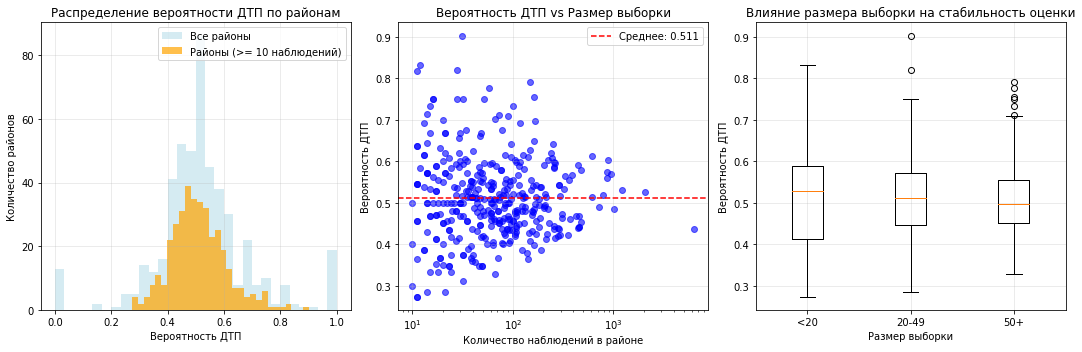

In [92]:
# Визуализация распределения с фильтрацией
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(district_stats['fault_rate'], bins=30, alpha=0.5, label='Все районы', color='lightblue')
plt.hist(filtered_districts['fault_rate'],
         bins=30, alpha=0.7,
         label=f'Районы (>= {min_observations} наблюдений)', color='orange')
plt.xlabel('Вероятность ДТП')
plt.ylabel('Количество районов')
plt.title('Распределение вероятности ДТП по районам')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.scatter(filtered_districts['total_count'], filtered_districts['fault_rate'], 
           alpha=0.6, color='blue')
plt.xlabel('Количество наблюдений в районе')
plt.ylabel('Вероятность ДТП')
plt.title('Вероятность ДТП vs Размер выборки')
plt.axhline(y=filtered_districts['fault_rate'].mean(), color='red', linestyle='--', 
           label=f'Среднее: {filtered_districts["fault_rate"].mean():.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')

plt.subplot(1, 3, 3)
# boxplot для сравнения распределений
box_data = [
    filtered_districts[filtered_districts['total_count'] < 20]['fault_rate'],
    filtered_districts[(filtered_districts['total_count'] >= 20) & (filtered_districts['total_count'] < 50)]['fault_rate'],
    filtered_districts[filtered_districts['total_count'] >= 50]['fault_rate']
]
plt.boxplot(box_data, labels=['<20', '20-49', '50+'])
plt.xlabel('Размер выборки')
plt.ylabel('Вероятность ДТП')
plt.title('Влияние размера выборки на стабильность оценки')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

График распределений вероятностей ДТП по районам указывает на то, что распределения по всем районам и районам с количеством случаев больше или равно 10 имеют схожий вид с пиком в районе вероятности 0.5. График вероятности ДТП против размера выборки демонстрирует большое количество районов с вероятностью больше 0.5 и меньше 0.5, а также районы с аномально большим количеством наблюдений. Диаграммы boxplot для разных размеров выборок в очередной раз подтверждают логичность выбора вероятности 0.5 в качестве критерия для некоторого безопасного района.

**Промежуточные выводы по анализу признака `county_city_location`**

Учитывая детальный анализ географического фактора `county_city_location`, который оказался важным для классификации виновника ДТП по модели `CatBoostClassifier`, можно сделать вывод, что есть некоторый порог вероятности 0.5, который можно считать приемлемым. В каждом "опасном" районе, где вероятность ДТП больше порога, можно уведомлять водителя, который берет в аренду ТС о том, что район с высоким риском попадания в ДТП. Тем самым есть шанс увеличить вовлеченность водителя в движение и снизить в "опасных" районах вероятность ДТП. Для этого в машине должно быть установлено устройство, определяющее его местоположение. 

## Выводы

*Краткое описание лучшей модели*

Лучшей моделью из исследуемых стала `CatBoostClassifier`. Модель показывает умеренное качество — F1-score ≈ 0.62, что указывает на среднюю эффективность классификации. Вероятно для улучшение метрик требуются более информативные признаки. Согласное модели `CatBoostClassifier` в топ-3 самых важных факторов, влияющих на вероятность ДТП, вошли `insurance_premium`, `vehicle_type`, `county_city_location`. Признак `insurance_premium` имеет преимущественно меньшее значение для виновников ДТП, тип авто `coupe` оказывается вероятнее у виновников ДТП. По признаку `county_city_location` установлен некоторый порог вероятности ДТП в зависимости от района равный 0.5. В районах с вероятностью ДТП, превышающим пороговое значение, рекомендуется уведомлять водителей о повышенной опасности на дороге.

*Насколько возможно создание адекватной системы оценки риска при выдаче авто?*

Полученные результаты указывают на сложности создания качественной системы оценки риска при выдаче авто. Существующие данные могут быть недостаточными для высокой точности прогноза. Рыночные условия, экономическая ситуация и поведение клиентов постоянно меняются, что может вводить в заблуждения различные модели.

*Какие факторы ещё необходимо собирать, чтобы улучшить модель?*

1. Финансовые данные
    - История кредитов: Полную кредитную историю из бюро кредитных историй
    - Имущественное положение: Наличие недвижимости, других активов
    - Задолженности: Текущие обязательства, просрочки по другим кредитам
2. Поведенческие данные
    - Паттерны использования телефона/интернета: Анализ цифрового поведения
    - Социальные связи: Данные из социальных сетей (с согласия клиента)
3. Макроэкономические факторы
    - Региональные экономические индикаторы: Уровень безработицы, средние зарплаты по регионам
    - Индустриальные тренды: Изменения в автомобильной отрасли
4. Регуляторные данные
    - Юридическая история: Наличие судимостей, арестов, банкротств
    - Страховая история: Претензии по страховке, ДТП
    - Налоговые данные: Своевременность уплаты налогов